# "they're good dogs Brent." -- [@dog_rates](https://twitter.com/dog_rates/status/775410014383026176?lang=en)

# Introduction

> The dataset that you will be wrangling (and analyzing and visualizing) is the tweet archive of Twitter user [@dog_rates](https://twitter.com/dog_rates), also known as [WeRateDogs](https://en.wikipedia.org/wiki/WeRateDogs). WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc. Why? Because "they're good dogs Brent." WeRateDogs has over 4 million followers and has received international media coverage.
>
>    -- Udacity

# Gathering Data

I gathered data from the three different sources.

## Source 1 - the WeRateDogs Twitter archive.

I downloaded this file manually by from the following link: [twitter_archive_enhanced.csv](https://d17h27t6h515a5.cloudfront.net/topher/2017/August/59a4e958_twitter-archive-enhanced/twitter-archive-enhanced.csv)

In [1]:
import pandas as pd

In [2]:
arch = pd.read_csv('twitter-archive-enhanced.csv')
arch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

## Source 2 - the tweet image predictions

This file hosted on Udacity's servers and I downloaded it programmatically using the [Requests](http://docs.python-requests.org/en/master/) library from the following URL: [image_predictions.tsv](https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv).

In [3]:
import requests
import io

In [4]:
URL = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
content = requests.get(URL).content
pred = pd.read_csv(io.StringIO(content.decode('utf-8')), sep='\t')
pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


## Source 3 -  Twitter API

Using the tweet_ids in the WeRateDogs Twitter archive, I query the Twitter API for each tweet_id and store each tweet's entire set of JSON data in a file called tweet_json.txt. Each tweet's JSON data written to its one line.

In [5]:
import json
import tweepy

# ! pip install tqdm
from tqdm import tqdm_notebook

In [6]:
# reads the JSON file to Data Frame or creates the empty Data Frame
try:
    api = pd.read_json('tweet_json.txt', lines=True)
except:
    api = pd.DataFrame(columns=['id'])

In [7]:
# makes the list of tweet_id that present in the archive, but absent in JSON file 
tweet_id_list = sorted(list(set(arch.tweet_id) - set(api.id)))
print('Number of tweets has left to download =', len(tweet_id_list))

Number of tweets has left to download = 5


In [8]:
# reads my Twitter API keys and access tokens from file 'MyKeysTwitterAPI.json'
with open('MyKeysTwitterAPI.json', 'r') as f:
    api_keys = json.load(f)
    auth = tweepy.OAuthHandler(api_keys['consumer_key'], api_keys['consumer_secret'])
    auth.set_access_token(api_keys['access_token'], api_keys['access_secret'])
    twitter = tweepy.API(auth, wait_on_rate_limit_notify=True)

    # queries to the Twitter API and appends JSON answer in the file 'tweet_json.txt'
    with open('tweet_json.txt', 'a') as outfile:  
#         for tweet_id in tweet_id_list:
        for tweet_id in tqdm_notebook(tweet_id_list):
            try:
                tweet = twitter.get_status(tweet_id, tweet_mode='extended')
                json.dump(tweet._json, outfile)
                outfile.writelines('\n')
            except tweepy.error.TweepError as err:
                print(tweet_id, err.args[0][0])

A Jupyter Widget

775096608509886464 {'code': 144, 'message': 'No status found with that ID.'}
802247111496568832 {'code': 144, 'message': 'No status found with that ID.'}
861769973181624320 {'code': 144, 'message': 'No status found with that ID.'}
869988702071779329 {'code': 144, 'message': 'No status found with that ID.'}
888202515573088257 {'code': 144, 'message': 'No status found with that ID.'}



In [9]:
from pandas.io.json import json_normalize
from collections import defaultdict
data = defaultdict(list)

with open('tweet_json.txt', 'r') as infile:
    for line in infile:
        tmp = json.loads(line.strip())

        data['tweet_id'].append(tmp['id_str'])
        data['retweet_count'].append(tmp['retweet_count'])
        data['favorite_count'].append(tmp['favorite_count'])

        if tmp['in_reply_to_user_id_str']:
            data['in_reply_to_user_id'].append(tmp['in_reply_to_user_id_str'])
            data['in_reply_to_status_id'].append(tmp['in_reply_to_status_id_str'])
        else:
            data['in_reply_to_user_id'].append('')
            data['in_reply_to_status_id'].append('')

        if 'retweeted_status' in tmp.keys():
            data['retweeted_status_id'].append(tmp['retweeted_status']['id_str'])
            data['retweeted_status_user_id'].append(tmp['retweeted_status']['user']['id_str'])
            point = pd.to_datetime(tmp['retweeted_status']['created_at'])
            data['retweeted_status_timestamp'].append(point)
        else:
            data['retweeted_status_id'].append('')
            data['retweeted_status_user_id'].append('')
            data['retweeted_status_timestamp'].append(None)

api = pd.DataFrame.from_dict(data, orient='columns')

api = api[["tweet_id", "retweet_count", "favorite_count",
           "in_reply_to_user_id", "in_reply_to_status_id",
           "retweeted_status_id", "retweeted_status_user_id", "retweeted_status_timestamp"]]
api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2351 entries, 0 to 2350
Data columns (total 8 columns):
tweet_id                      2351 non-null object
retweet_count                 2351 non-null int64
favorite_count                2351 non-null int64
in_reply_to_user_id           2351 non-null object
in_reply_to_status_id         2351 non-null object
retweeted_status_id           2351 non-null object
retweeted_status_user_id      2351 non-null object
retweeted_status_timestamp    176 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 147.0+ KB


# Assessing data

In [10]:
# service variables
quality = {'arch': list()}
tidiness = list()

## Visual assessment

In [11]:
arch

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [12]:
quality['arch'].append('"name" sometimes include other words as "a", "an", "the", "quite" ...')
quality['arch'].append('"retweeted_status_id" is a float not string')
quality['arch'].append('"retweeted_status_user_id" is a float not string')
quality['arch'].append('"doggo", "floofer", "pupper", and "puppo" include word "None"')
tidiness.append('"doggo", "floofer", "pupper", and "puppo" can joined in one column "dogtionary"')

In [13]:
pred

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [14]:
api

,tweet_id,retweet_count,favorite_count,in_reply_to_user_id,in_reply_to_status_id,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp
0,892420643555336193,8809,39412,,,,,NaT
1,892177421306343426,6458,33739,,,,,NaT
2,891815181378084864,4281,25408,,,,,NaT
3,891689557279858688,8891,42781,,,,,NaT
4,891327558926688256,9687,40939,,,,,NaT
5,891087950875897856,3226,20521,,,,,NaT
6,890971913173991426,2133,12034,,,,,NaT
7,890729181411237888,19498,66595,,,,,NaT
8,890609185150312448,4378,28158,,,,,NaT
9,890240255349198849,7652,32404,,,,,NaT


In [15]:
tidiness.append('"api" table and "pred" table should be part of the "arch" table')
tidiness.append('all tables have the different number of rows')

## Programmatic assessment

In [16]:
arch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [17]:
# write data quality issues
quality['arch'].append('"tweet_id" is an integer not string')
quality['arch'].append('"in_reply_to_status_id" is a float not string')
quality['arch'].append('"in_reply_to_user_id" is a float not string')
quality['arch'].append('"timestamp" is an object not datatime')
quality['arch'].append('"retweeted_status_timestamp" is an object not datatime')
quality['arch'].append('"rating_numerator" is an integer not float')
quality['arch'].append('"rating_denominator" is an integer not float')

In [18]:
arch.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [19]:
# write data quality issues
quality['arch'].append('column "source" has information about the tag "a"')

In [20]:
arch.expanded_urls.head().values

array(['https://twitter.com/dog_rates/status/892420643555336193/photo/1',
       'https://twitter.com/dog_rates/status/892177421306343426/photo/1',
       'https://twitter.com/dog_rates/status/891815181378084864/photo/1',
       'https://twitter.com/dog_rates/status/891689557279858688/photo/1',
       'https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1'], dtype=object)

In [21]:
# write data quality issues
quality['arch'].append('some "expanded_urls" includes more than one URL separated by the comma')

In [22]:
print(arch[(arch.doggo != 'doggo') & (arch.text.str.contains(' doggos '))].text.values)

[ 'I can say with the pupmost confidence that the doggos who assisted with this search are heroic as h*ck. 14/10 for all https://t.co/8yoc1CNTsu'
 'Here we have some incredible doggos for #K9VeteransDay. All brave as h*ck. Salute your dog in solidarity. 14/10 for all https://t.co/SVNMdFqKDL'
 'RT @SchafeBacon2016: @dog_rates Slightly disturbed by the outright profanity, but confident doggos were involved. 11/10, would tailgate aga…'
 "RT @dog_rates: Meet Jack. He's one of the rare doggos that doesn't mind baths. 11/10 click the link to see how you can help Jack!\n\nhttps://…"
 "Meet Jack. He's one of the rare doggos that doesn't mind baths. 11/10 click the link to see how you can help Jack!\n\nhttps://t.co/r4W111FzAq https://t.co/fQpYuMKG3p"
 'You need to watch these two doggos argue through a cat door. Both 11/10 https://t.co/qEP31epKEV'
 'Here are three doggos completely misjudging an airborne stick. Decent efforts tho. All 9/10 https://t.co/HCXQL4fGVZ'
 "This is Dietrich. He hops at

In [23]:
# write data quality issues
quality['arch'].append('some "doggo" do not have the tag when text have those words in the plural form ')

In [24]:
print(arch[(arch.pupper != 'pupper') & (arch.text.str.contains(' puppers '))].text.values)

[ "This is one of the most reckless puppers I've ever seen. How she got a license in the first place is beyond me. 6/10 https://t.co/z5bAdtn9kd"
 'This is Arlen and Thumpelina. They are best pals. Cuddly af. 11/10 for both puppers https://t.co/VJgbgIzIHx'
 "Everybody stop what you're doing and watch these puppers enjoy summer. Both 13/10 https://t.co/wvjqSCN6iC"
 "Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1"
 'Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3'
 'Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55'
 'Gang of fearless hoofed puppers here. Straight savages. Elevated for extra terror. Front one has killed before 6/10s https://t.co/jkCb25OWfh'
 "Meet Sadie. She fell asleep on the beach and her friends buried her. 10/10 can't trust fellow puppers these days https

In [25]:
# write data quality issues
quality['arch'].append('some "pupper" do not have the tag when text have those words in the plural form ')

In [26]:
print(arch[(arch.puppo != 'puppo') & (arch.text.str.contains(' puppos '))].text.head().values)

['@0_kelvin_0 &gt;10/10 is reserved for puppos sorry Kevin']


In [27]:
# write data quality issues
quality['arch'].append('one "puppo" do not have the tag when text have those words in the plural form ')

In [28]:
pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [29]:
# write data quality issues
quality['pred'] = list()
quality['pred'].append('"tweet_id" is an integer not string')

In [30]:
api.sample(5).T

,2296,1968,606,749,1494
tweet_id,759943073749200896,715200624753819648,797236660651966464,778774459159379968,666058600524156928
retweet_count,2365,2094,7674,11451,61
favorite_count,6541,5554,22234,0,118
in_reply_to_user_id,,,,,
in_reply_to_status_id,,,,,
retweeted_status_id,,,,758099635764359168,
retweeted_status_user_id,,,,4196983835,
retweeted_status_timestamp,NaT,NaT,NaT,2016-07-27 00:40:12,NaT


In [31]:
print('Quality')
for part in quality.keys():
    print('\n  "%s" table:' % (part))
    for item in quality[part]:
        print('    -', item)
        
print('\n\nTidiness\n')
for item in tidiness:
    print('    -', item)        

Quality

  "arch" table:
    - "name" sometimes include other words as "a", "an", "the", "quite" ...
    - "retweeted_status_id" is a float not string
    - "retweeted_status_user_id" is a float not string
    - "doggo", "floofer", "pupper", and "puppo" include word "None"
    - "tweet_id" is an integer not string
    - "in_reply_to_status_id" is a float not string
    - "in_reply_to_user_id" is a float not string
    - "timestamp" is an object not datatime
    - "retweeted_status_timestamp" is an object not datatime
    - "rating_numerator" is an integer not float
    - "rating_denominator" is an integer not float
    - column "source" has information about the tag "a"
    - some "expanded_urls" includes more than one URL separated by the comma
    - some "doggo" do not have the tag when text have those words in the plural form 
    - some "pupper" do not have the tag when text have those words in the plural form 
    - one "puppo" do not have the tag when text have those words in the

# Cleaning Data

In [32]:
arch_clean = arch.copy()
pred_clean = pred.copy()
api_clean = api.copy()

## In tables "arch" and "pred" the column "tweet_id" is an integer not string

### Define

Change type of column to string

### Code

In [33]:
arch_clean['tweet_id'] = arch_clean.tweet_id.astype('str')
pred_clean['tweet_id'] = pred_clean.tweet_id.astype('str')

### Test

In [34]:
arch_clean[['tweet_id']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 1 columns):
tweet_id    2356 non-null object
dtypes: object(1)
memory usage: 18.5+ KB


In [35]:
pred_clean[['tweet_id']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 1 columns):
tweet_id    2075 non-null object
dtypes: object(1)
memory usage: 16.3+ KB


## Columns "retweeted_status_id", "retweeted_status_user_id", "in_reply_to_status_id", and "in_reply_to_user_id" are a float numbers. But those all values of identificators and must be string.

### Define

Identify the source of errors and maybe download again the csv file.

### Code

In [36]:
# check in_reply_to_user_id
check_id = max(arch_clean[arch_clean.in_reply_to_user_id.notnull()].in_reply_to_user_id)
check_tweet = arch_clean[arch_clean.in_reply_to_user_id == check_id][['tweet_id']].values[0][0]
! cat 'twitter-archive-enhanced.csv' | grep $check_tweet

840698636975636481,8.406983002988626e+17,8.405478643549184e+17,2017-03-11 22:59:09 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@0_kelvin_0 &gt;10/10 is reserved for puppos sorry Kevin,,,,,10,10,None,None,None,None,None


In [37]:
api_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2351 entries, 0 to 2350
Data columns (total 8 columns):
tweet_id                      2351 non-null object
retweet_count                 2351 non-null int64
favorite_count                2351 non-null int64
in_reply_to_user_id           2351 non-null object
in_reply_to_status_id         2351 non-null object
retweeted_status_id           2351 non-null object
retweeted_status_user_id      2351 non-null object
retweeted_status_timestamp    176 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 147.0+ KB


In [38]:
api_clean[api_clean.tweet_id == check_tweet][['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id']]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id
271,840698636975636481,840698300298862592,840547864354918400


We see that data corrupted in CSV file then we can delete columns in table "arch" and take right date from table "api_clean."

The same situation we see in columns "retweeted_status_id", "retweeted_status_user_id" and "retweeted_status_timestamp".

In [39]:
# check retweeted_status_user_id
check_id = max(arch_clean[arch_clean.retweeted_status_user_id.notnull()].retweeted_status_user_id)
check_tweet = arch_clean[arch_clean.retweeted_status_user_id == check_id][['tweet_id']].values[0][0]
! cat 'twitter-archive-enhanced.csv' | grep $check_tweet

867072653475098625,,,2017-05-23 17:40:04 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @rachaeleasler: these @dog_rates hats are 13/10 bean approved https://t.co/nRCdq4g9gG,8.650134204453683e+17,7.874617784352891e+17,2017-05-18 01:17:25 +0000,"https://twitter.com/rachaeleasler/status/865013420445368320/photo/1,https://twitter.com/rachaeleasler/status/865013420445368320/photo/1,https://twitter.com/rachaeleasler/status/865013420445368320/photo/1,https://twitter.com/rachaeleasler/status/865013420445368320/photo/1",13,10,None,None,None,None,None


In [40]:
api_clean[api_clean.tweet_id == check_tweet][['tweet_id', 'retweeted_status_id',
                                              'retweeted_status_user_id', 'retweeted_status_timestamp']]

,tweet_id,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp
128,867072653475098625,865013420445368320,787461778435289088,2017-05-18 01:17:25


In [41]:
arch_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id',
                'retweeted_status_id', 'retweeted_status_user_id',
                'retweeted_status_timestamp'], axis=1, inplace=True)

### Test

In [42]:
arch_clean.sample(4).T

,777,1838,1063,566
tweet_id,776088319444877312,675898130735476737,741067306818797568,802247111496568832
timestamp,2016-09-14 16:00:49 +0000,2015-12-13 04:40:46 +0000,2016-06-10 00:39:48 +0000,2016-11-25 20:26:31 +0000
source,"<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r..."
text,I can't tap the screen to make the hearts appe...,I'm sure you've all seen this pupper. Not prep...,This is just downright precious af. 12/10 for ...,RT @dog_rates: Everybody drop what you're doin...
expanded_urls,https://twitter.com/dog_rates/status/776088319...,https://twitter.com/dog_rates/status/675898130...,https://twitter.com/dog_rates/status/741067306...,https://twitter.com/dog_rates/status/779056095...
rating_numerator,10,10,12,13
rating_denominator,10,10,10,10
name,None,None,just,None
doggo,None,None,doggo,None
floofer,None,None,None,None


## Some "doggo", "pupper" and "puppo" do not have the tag when text have those words in the plural form.

### Define

Find the missing data and check the possibility to merge columns ("doggo", "floofer", "pupper", and "puppo") into one column "dogtionary".

### Code

In [43]:
# fixes missing data
for id in arch[(arch_clean.doggo != 'doggo') & (arch_clean.text.str.contains(' doggos'))].index:
    arch_clean.loc[id, 'doggo'] = 'doggo'

for id in arch[(arch_clean.puppo != 'puppo') & (arch_clean.text.str.contains(' puppos'))].index:
    arch_clean.loc[id, 'puppo'] = 'puppo'

for id in arch[(arch_clean.pupper != 'pupper') & (arch_clean.text.str.contains(' puppers'))].index:
    arch_clean.loc[id, 'pupper'] = 'pupper'

In [44]:
# check the independence of the columns "doggo", "floofer", "pupper", and "puppo"

for i in arch_clean.index:
    check, names = 0, list()
    for name in ["puppo", "pupper", "doggo", "floofer"]:
        if arch_clean.loc[i, name] == name:
            check += 1
            names.append(name)
    if check > 1:
        print(check, names, arch_clean.loc[i, 'text'])

2 ['puppo', 'doggo'] Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel
2 ['doggo', 'floofer'] At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk
2 ['pupper', 'doggo'] This is Dido. She's playing the lead role in "Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple." 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7
2 ['pupper', 'doggo'] Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho
2 ['pupper', 'doggo'] Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze
2 ['pupper', 'doggo'] This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj
2 ['pupper', 'doggo

We can see that two columns can have value at the same time and that is not an error of data set. Then when we make one column "dogtionary," we must join two value in one column.

### Test

In [45]:
# finds all text with words ("doggo", "floofer", "pupper", "puppo") but without tag in column
for i in arch_clean.index:
    check = 0
    for name in ["doggo", "floofer", "pupper", "puppo"]:
        if ((arch_clean.loc[i, name] != name) & ((' ' + name) in arch_clean.loc[i, 'text'].lower())):
            print('<',name, '> ', arch_clean.loc[i, 'text'])

< pupper >  This is Gary. He couldn't miss this puppertunity for a selfie. Flawless focusing skills. 13/10 would boop intensely https://t.co/7CSWCl8I6s
< puppo >  Meet Venti, a seemingly caffeinated puppoccino. She was just informed the weekend would include walks, pats and scritches. 13/10 much excite https://t.co/ejExJFq3ek
< puppo >  This is Lili. She can't believe you betrayed her with bath time. Never looking you in the eye again. 12/10 would puppologize profusely https://t.co/9b9J46E86Z
< puppo >  I have stumbled puppon a doggo painting party. They're looking to be the next Pupcasso or Puppollock. All 13/10 would put it on the fridge https://t.co/cUeDMlHJbq
< pupper >  This is Lennon. He's a Boopershnoop Pupperdoop. Quite rare. Exceptionally pettable. 12/10 would definitely boop that shnoop https://t.co/fhgP6vSfhX
< puppo >  This is Duke. He is not a fan of the pupporazzi. 12/10 https://t.co/SgpBVYIL18
< pupper >  IT'S PUPPERGEDDON. Total of 144/120 ...I think https://t.co/ZanVtA

All those texts don't need any tag.

# Tidiness

## "doggo", "floofer", "pupper", and "puppo" can joined in one column "dogtionary"**

### Define

Create a function for combining four columns. Make a column "dictionary" and delete the previous four columns.

### Code

In [46]:
def dogtionary(row):
    names = ("puppo", "pupper", "doggo", "floofer")
    out = [name for name in names if row[name] == name]
    return ' '.join(out) if out else ''

arch_clean['dogtionary'] = arch_clean.apply(dogtionary, axis=1)
arch_clean.drop(["puppo", "pupper", "doggo", "floofer"], axis=1, inplace=True)

### Test

In [47]:
arch_clean.dogtionary.value_counts()

                 1943
pupper            266
doggo              93
puppo              31
pupper doggo       12
floofer             9
doggo floofer       1
puppo doggo         1
Name: dogtionary, dtype: int64

In [48]:
arch_clean[arch_clean.dogtionary != ''].sample(4).T

,1608,815,1992,1334
tweet_id,685641971164143616,771004394259247104,672614745925664768,705428427625635840
timestamp,2016-01-09 01:59:19 +0000,2016-08-31 15:19:06 +0000,2015-12-04 03:13:46 +0000,2016-03-03 16:23:38 +0000
source,"<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r..."
text,This is Otis. He just passed a cop while going...,RT @katieornah: @dog_rates learning a lot at c...,This is Norman. Doesn't bark much. Very docile...,This is Ambrose. He's an Alfalfa Ballyhoo. Dra...
expanded_urls,https://twitter.com/dog_rates/status/685641971...,https://twitter.com/katieornah/status/77100213...,https://twitter.com/dog_rates/status/672614745...,https://twitter.com/dog_rates/status/705428427...
rating_numerator,7,12,6,11
rating_denominator,10,10,10,10
name,Otis,None,Norman,Ambrose
dogtionary,pupper,pupper,pupper,pupper


## "api" table and "pred" table should be part of the "arch" table and all tables have the different number of rows


### Define

I make a set of unique tweet_id for all data frames and then merge all data frames using this set of tweet_id.

### Code

In [49]:
tweet_set = set(arch_clean['tweet_id']) & set(pred_clean['tweet_id']) & set(api_clean['tweet_id'])

In [50]:
master = pd.merge(arch_clean[arch_clean.tweet_id.isin(tweet_set)], pred_clean, on=['tweet_id'], how='left')
master = pd.merge(master, api_clean, on=['tweet_id'], how='left')

### Test

In [51]:
master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2072 entries, 0 to 2071
Data columns (total 27 columns):
tweet_id                      2072 non-null object
timestamp                     2072 non-null object
source                        2072 non-null object
text                          2072 non-null object
expanded_urls                 2072 non-null object
rating_numerator              2072 non-null int64
rating_denominator            2072 non-null int64
name                          2072 non-null object
dogtionary                    2072 non-null object
jpg_url                       2072 non-null object
img_num                       2072 non-null int64
p1                            2072 non-null object
p1_conf                       2072 non-null float64
p1_dog                        2072 non-null bool
p2                            2072 non-null object
p2_conf                       2072 non-null float64
p2_dog                        2072 non-null bool
p3                            2

# Quality

## "timestamp", "retweeted_status_timestamp" is an object not datatime

### Define

Convert "timestamp" and "retweeted_status_timestamp" to datatime.

### Code

In [52]:
master['timestamp'] = pd.to_datetime(master.timestamp)
master['retweeted_status_timestamp'] = pd.to_datetime(master.retweeted_status_timestamp)

### Test

In [53]:
master[['timestamp', 'retweeted_status_timestamp']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2072 entries, 0 to 2071
Data columns (total 2 columns):
timestamp                     2072 non-null datetime64[ns]
retweeted_status_timestamp    78 non-null datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 48.6 KB


## "name" sometimes include other words as "a", "an", "the", "quite" ...

### Define

Delete from column "name" the words that are not like a dogs name.

### Code

In [54]:
bad_names = sorted(master.name.unique())[-22:] + ['None']
print(bad_names)

['a', 'actually', 'all', 'an', 'by', 'getting', 'his', 'incredibly', 'infuriating', 'just', 'light', 'my', 'not', 'officially', 'one', 'quite', 'space', 'such', 'the', 'this', 'unacceptable', 'very', 'None']


In [55]:
master['name'] = master.name.apply(lambda x: '' if x in bad_names else x)

### Test

In [56]:
assert (set(master.name) & set(bad_names)) == set()

##  Some "expanded_urls" includes more than one URL separated by the comma


### Define

Convert "timestamp" and "retweeted_status_timestamp" to datatime.

### Code

In [57]:
master['expanded_urls'] = master.expanded_urls.apply(lambda x: tuple(x.split(',')) if x != '' else tuple())

### Test

In [58]:
master.expanded_urls.values[:5]

array([('https://twitter.com/dog_rates/status/892420643555336193/photo/1',),
       ('https://twitter.com/dog_rates/status/892177421306343426/photo/1',),
       ('https://twitter.com/dog_rates/status/891815181378084864/photo/1',),
       ('https://twitter.com/dog_rates/status/891689557279858688/photo/1',),
       ('https://twitter.com/dog_rates/status/891327558926688256/photo/1', 'https://twitter.com/dog_rates/status/891327558926688256/photo/1')], dtype=object)

## Garbage in column "source"

### Define

In column "source" I leave the only body of tag us in [documentation](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object).

### Code

In [59]:
master['source'] = master.source.str.extract('.*\>(.*)\<.*', expand=True)

### Test

In [60]:
master.source.value_counts()

Twitter for iPhone    2031
Twitter Web Client      30
TweetDeck               11
Name: source, dtype: int64

##  "rating_numerator" and "rating_denominator" are integers not float

### Define

Convert "rating_numerator" and "rating_denominator" from integer to float

### Code

In [61]:
master['rating_numerator'] = master.rating_numerator.astype('float')
master['rating_denominator'] = master.rating_denominator.astype('float')

### Test

In [62]:
master[['rating_numerator','rating_denominator']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2072 entries, 0 to 2071
Data columns (total 2 columns):
rating_numerator      2072 non-null float64
rating_denominator    2072 non-null float64
dtypes: float64(2)
memory usage: 48.6 KB


# Storing data

In [63]:
master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2072 entries, 0 to 2071
Data columns (total 27 columns):
tweet_id                      2072 non-null object
timestamp                     2072 non-null datetime64[ns]
source                        2072 non-null object
text                          2072 non-null object
expanded_urls                 2072 non-null object
rating_numerator              2072 non-null float64
rating_denominator            2072 non-null float64
name                          2072 non-null object
dogtionary                    2072 non-null object
jpg_url                       2072 non-null object
img_num                       2072 non-null int64
p1                            2072 non-null object
p1_conf                       2072 non-null float64
p1_dog                        2072 non-null bool
p2                            2072 non-null object
p2_conf                       2072 non-null float64
p2_dog                        2072 non-null bool
p3                 

In [64]:
master.to_csv('twitter_archive_master.csv', index=False)

In [65]:
%pylab inline

import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


/home/vikalyuk/bin/anaconda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


###### report

# Acting on Wrangled Data

## How many days can we see the activity of this account?

In [66]:
print('We have data from:', master.timestamp.min(), 'to:', master.timestamp.max())

We have data from: 2015-11-15 22:32:08 to: 2017-08-01 16:23:56


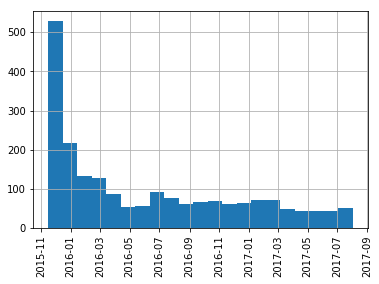

In [67]:
master.timestamp.hist(bins=21, xrot=90);

WeRateDogs had most tweets at December 2015, but at other intervals, we can see less 100 tweets in a month.

## Top 10 of scores in the rating system.

In [68]:
rate = lambda row: str(row['rating_numerator']) + '/' \
                   + str(row['rating_denominator'])
master.apply(rate, axis=1).value_counts()[:10]

12.0/10.0    474
10.0/10.0    429
11.0/10.0    413
13.0/10.0    281
9.0/10.0     150
8.0/10.0      95
7.0/10.0      51
14.0/10.0     40
5.0/10.0      34
6.0/10.0      32
dtype: int64

In [69]:
print(round(sum(master.apply(rate, axis=1).value_counts()[:4].values)
            / len(master) * 100), '% tweets have rate from 10/10 to 13/10')

77.0 % tweets have rate from 10/10 to 13/10


## About correlation between likes and retweets

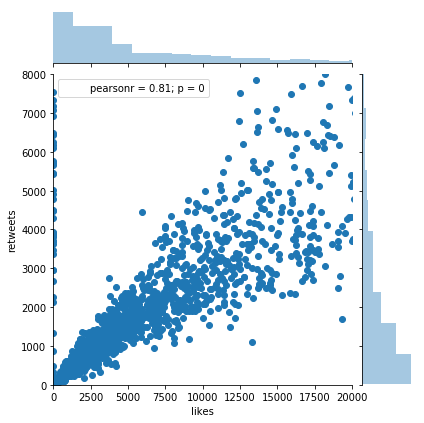

In [70]:
sns.jointplot(x=master["favorite_count"], y=master["retweet_count"],
              kind='scatter', marginal_kws=dict(bins=100), xlim=(0, 20000),
              ylim=(0, 8000)).set_axis_labels("likes", "retweets");

Likes correlate to retweets about 0.76, and we can see that every two likes bring one retweet.

In [71]:
print(len(master[(master.favorite_count == 0) & (master.retweet_count > 0)]),
      'tweets have retweets without any like.')

78 tweets have retweets without any like.


## Top 10 names of dogs

           676
Charlie     11
Tucker      10
Lucy        10
Oliver      10
Penny       10
Cooper      10
Bo           8
Lola         8
Sadie        8
Name: name, dtype: int64


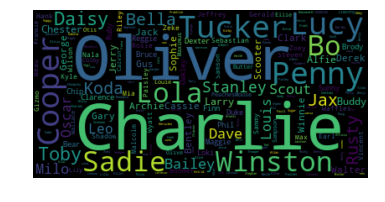

In [72]:
print(master[master.name.notnull() == True].name.value_counts()[:10])

names = ' '.join(list(master[master.name.notnull() == True].name))
wordcloud = WordCloud().generate(names)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

## About recognize picture of dogs

In [73]:
# how mamy dogs recognize
breeds = master[(master.p1_dog == True) |
                (master.p2_dog == True) |
                (master.p3_dog == True) ].copy()
print(len(breeds), 'pictures from', len(master),
      'tweets had recognized successful as a picture of the dog.')

1748 pictures from 2072 tweets had recognized successful as a picture of the dog.


In [74]:
def get_breed(row):
    breed, conf = '', 0.0
    if (row['p1_dog'] == True) and (row['p1_conf'] > conf):
        breed, conf = row['p1'], row['p1_conf']
        
    if (row['p2_dog'] == True) and (row['p2_conf'] > conf):
        breed, conf = row['p2'], row['p2_conf']
        
    if (row['p3_dog'] == True) and (row['p3_conf'] > conf):
        breed, conf = row['p3'], row['p3_conf']
        
    row['breed'] = breed
    row['conf'] = conf
    
    return row
    
breeds['breed'] = ''
breeds['conf'] = 0
breeds = breeds.apply(get_breed, axis=1)

In [75]:
print('We got', len(breeds.breed.unique()), 'names of a breed.')

We got 113 names of a breed.


In [76]:
print('Top 10 breeds')
breeds.breed.value_counts()[:10]

Top 10 breeds


golden_retriever      173
Labrador_retriever    113
Pembroke               95
Chihuahua              94
pug                    65
toy_poodle             52
chow                   51
Samoyed                46
Pomeranian             42
malamute               34
Name: breed, dtype: int64

In [77]:
print(round(len(breeds[breeds.conf >= 0.9]) / len(breeds) * 100, 2),
      '% breeds recognized with 90% confidence.')

16.93 % breeds recognized with 90% confidence.


In [78]:
print('Top 10 breeds recognized with 90% confidence.')
breeds[breeds.conf >= 0.9].breed.value_counts()[:10]

Top 10 breeds recognized with 90% confidence.


golden_retriever      40
pug                   26
Pembroke              26
Samoyed               22
Labrador_retriever    19
Pomeranian            16
Chihuahua             13
French_bulldog        12
chow                   9
Blenheim_spaniel       6
Name: breed, dtype: int64

In [79]:
# how meny breeds not recognize
pure_rec = set(breeds.breed.unique()) - set(breeds[breeds.conf >= 0.9].breed.unique())
print(len(pure_rec), '=',round(len(pure_rec) / len(breeds.breed.unique()) * 100, 2),
      '% breeds NOT recognized with 90% confidence.')

55 = 48.67 % breeds NOT recognized with 90% confidence.




###### background

# Tools for make report

I convert this file into MD-format and leave only parts of text between two tags: "**report**" and "**background**." Then I turn MD-file to PDF-file.

In [82]:
# convert to md-file
!jupyter nbconvert --to markdown wrangle_act.ipynb

[NbConvertApp] Converting notebook wrangle_act.ipynb to markdown
[NbConvertApp] Support files will be in wrangle_act_files/
[NbConvertApp] Making directory wrangle_act_files
[NbConvertApp] Making directory wrangle_act_files
[NbConvertApp] Making directory wrangle_act_files
[NbConvertApp] Writing 119174 bytes to wrangle_act.md


In [83]:
def clean_report(in_file, out_file):
    # remove background parts of the report
    out = False
    with open(in_file, 'r') as f_in:
        with open(out_file, 'w') as f_out:
            for line in f_in:
                if line.strip().startswith('###### report'):
                    out = True
                elif line.strip().startswith('###### background'):
                    out = False
                else:
                    if out:
                        f_out.write(line)

clean_report('wrangle_act.md', 'act_report.md')